In [1]:
from pathlib import Path
import sys
local_module_path = Path("../modules/model_wrapper")
sys.path.append(local_module_path.as_posix())
local_module_path = Path("../modules/data_transformers")
sys.path.append(local_module_path.as_posix())
local_module_path = Path("../modules/auxiliary")
sys.path.append(local_module_path.as_posix())
local_module_path = Path("../modules/constants")
sys.path.append(local_module_path.as_posix())

In [2]:
import data_transformers as dt
from model_wrapper import model_wrapper as mw
import constants as co
from auxiliary import loggers, plotScatterWithIdeal, create_precision_recall_plot

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer, accuracy_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

import pandas as pd
import numpy as np
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, confusion_matrix, average_precision_score, roc_auc_score, recall_score, \
precision_score, accuracy_score, precision_recall_curve
from sklearn.feature_selection import VarianceThreshold

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.decomposition import PCA

from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import BayesianRidge, LinearRegression, LogisticRegression, RidgeClassifier, RidgeClassifierCV

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from functools import partial

import pickle
import json

from IPython.display import IFrame

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)
random_seed = 42

%config Completer.use_jedi = False

In [3]:
l = loggers.get_logger(logger_name="logger")

In [4]:
def set_up_mlflow(experiment):
    server_ip = "10.210.200.190"
    os.environ['AWS_ACCESS_KEY_ID'] = 'mlflow'
    os.environ['AWS_SECRET_ACCESS_KEY'] = 'uSPmPqTZv4YQh8M7oMqq'
    os.environ['MLFLOW_S3_ENDPOINT_URL'] = f"http://{server_ip}:9000"
    mlflow.set_tracking_uri(f"http://{server_ip}:9002")
    mlflow.set_experiment(experiment)

In [5]:
l.info(os.environ['CONDA_DEFAULT_ENV'])

2022-06-09 08:41:32,996 - logger - INFO - rorgammaqsar2
2022-06-09 08:41:32,996 - logger - INFO - rorgammaqsar2


# Data load

In [6]:
smiles_column = "canonical_smiles_get_levels"
target_column = "IC50_nM"

max_level_activity = 13
train_data = pd.read_csv((co.DATA_DIR/"ror_gamma_homo_sapiens.csv").absolute().as_posix())
activity_columns = ["act_"+str(iii) for iii in range(max_level_activity)]
train_data["target_std"] = train_data[activity_columns].apply(lambda x: np.std(x), axis=1)
train_data["target_min"] = train_data[activity_columns].apply(lambda x: np.min(x), axis=1)
train_data["target_max"] = train_data[activity_columns].apply(lambda x: np.max(x), axis=1)
train_data["target_mean"] = train_data[activity_columns].apply(lambda x: np.mean(x), axis=1)
train_data["target_median"] = train_data[activity_columns].apply(lambda x: np.median(x[~np.isnan(x)]), axis=1)
train_data[target_column] = train_data["target_median"]
# here we exclude the molecules for which the std of the available measurements is significant 
target_std_threshold = 100
train_data = train_data[train_data["target_std"] < target_std_threshold]
train_data

,molregno,standard_value_get_mean,standard_units_get_levels,standard_type_get_levels,chembl_id_compound_get_levels,canonical_smiles_get_levels,act_0,act_1,act_2,act_3,act_4,act_5,act_6,act_7,act_8,act_9,act_10,act_11,act_12,target_std,target_min,target_max,target_mean,target_median,IC50_nM
0,2208,199.53,nM,IC50,CHEMBL38,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)C(C)(C)CCC1,199.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,199.53,199.53,199.53,199.53,199.53
1,40459,31900.00,nM,IC50,CHEMBL28721,O=C(O)C(S)C(S)C(=O)O,31900.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,31900.00,31900.00,31900.00,31900.00,31900.00
3,155592,10000.00,nM,IC50,CHEMBL418971,CC(C)(c1ccc(O)cc1)c1ccc(O)cc1,10000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10000.00,10000.00,10000.00,10000.00,10000.00
5,242555,80000.00,nM,IC50,CHEMBL358290,NS(=O)(=O)c1ccc(N/C(S)=N\CCc2ccccc2)cc1,80000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,80000.00,80000.00,80000.00,80000.00,80000.00
6,342149,10000.00,nM,IC50,CHEMBL382792,O=S(=O)(Nc1ccc(C(O)(C(F)(F)F)C(F)(F)F)cc1)c1cc...,10000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10000.00,10000.00,10000.00,10000.00,10000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2214,2459056,193.60,nM,IC50,CHEMBL4588625,C[C@H]1CN(C2CCc3ccc(NC(=O)c4cccc(C#N)c4)cc32)C...,193.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,193.60,193.60,193.60,193.60,193.60
2215,2459160,75.00,nM,IC50,CHEMBL4588729,O=C(O)c1ccc(-n2cc(C(=O)c3c(Cl)cccc3Cl)c3ccccc3...,75.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,75.00,75.00,75.00,75.00,75.00
2217,2462878,27.00,nM,IC50,CHEMBL4592447,Cc1cccc(Cl)c1C(=O)c1cn(-c2ccc(C(=O)O)cc2F)c2nc...,27.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,27.00,27.00,27.00,27.00,27.00
2218,2463217,357.70,nM,IC50,CHEMBL4592786,N#Cc1cccc(NC(=O)Nc2ccc3c(c2)C(N2CC4CCC(C2)N4C(...,357.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,357.70,357.70,357.70,357.70,357.70


In [7]:
#tmp = train_data[["molregno", smiles_column, target_column]].set_index("molregno")
#tmp.columns = ["smiles", "target"]
#tmp.sample(n=1000).to_csv("test_data_large.csv", index=True)

# Data

In [8]:
smiles_codes = train_data["canonical_smiles_get_levels"].copy()
target = train_data["IC50_nM"].copy()

non_idx = dt.validate_smiles(smiles_codes=smiles_codes)
smiles_codes = smiles_codes.drop(non_idx, axis=0)
target = target.drop(non_idx, axis=0)

pipeline_file = "pipeline_configuration_XGBoost_regression.json"
pipeline_configuration = dt.read_in_pipeline(pipeline_file=pipeline_file, pipeline_directory=co.PIPELINE_DIR)
pipeline = dt.create_pipeline(pipeline_configuration=pipeline_configuration["feature_transform"])

y_train = dt.process_taget(pipeline_configuration=pipeline_configuration["target_transform"], y=target)
smiles_codes = smiles_codes.loc[y_train.index]

pipeline.fit(X=smiles_codes, y=None)
X_train = dt.create_molecular_features(pipeline=pipeline, smiles_codes=smiles_codes)
X_train = dt.process_molecular_features(pipeline=pipeline, X=X_train)

2022-06-09 08:41:38,378 - logger - INFO - CreateFPS fit...
2022-06-09 08:41:38,378 - logger - INFO - CreateFPS fit...
2022-06-09 08:41:38,379 - logger - INFO - CreateFPS transform...
2022-06-09 08:41:38,379 - logger - INFO - CreateFPS transform...
100%|██████████| 2039/2039 [00:02<00:00, 804.86it/s]


array([[<AxesSubplot:title={'center':'SLogP'}>,
        <AxesSubplot:title={'center':'SMR'}>],
       [<AxesSubplot:title={'center':'naRing'}>,
        <AxesSubplot:title={'center':'nHBAcc'}>]], dtype=object)

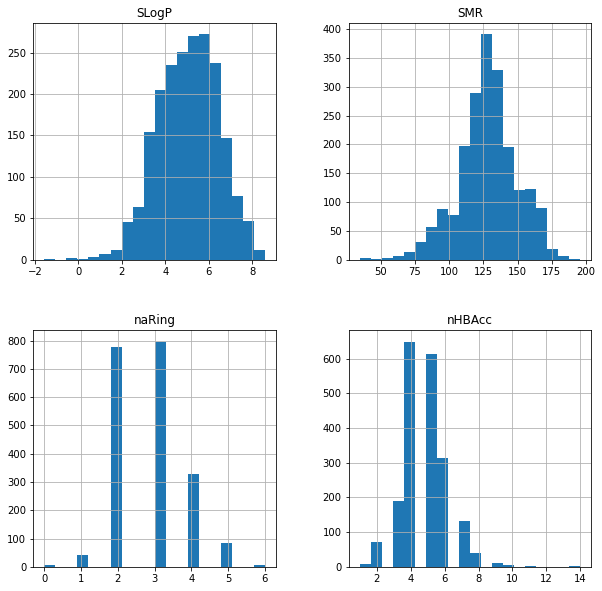

In [9]:
MDs = ["SLogP", "SMR", "naRing", "nHBAcc", "nHBDon", "nRot", "MW", "TopoPSA", "QED"]
X_train[MDs[:4]].hist(bins=20, grid=True, figsize=(10, 10))

array([[<AxesSubplot:title={'center':'nHBDon'}>,
        <AxesSubplot:title={'center':'nRot'}>],
       [<AxesSubplot:title={'center':'MW'}>,
        <AxesSubplot:title={'center':'TopoPSA'}>]], dtype=object)

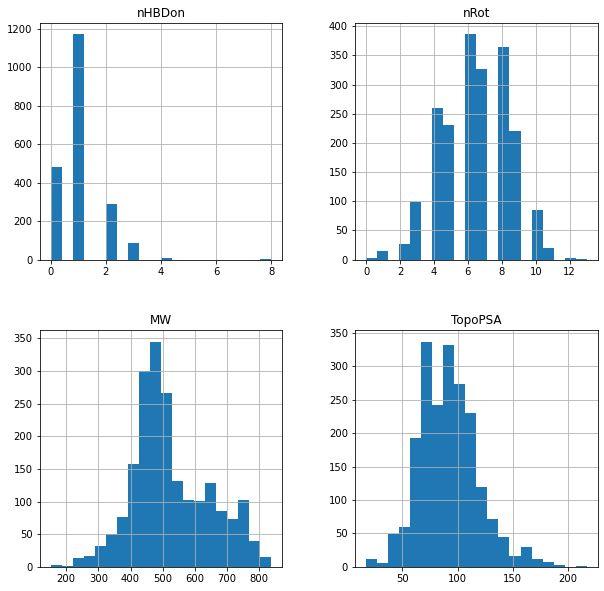

In [10]:
X_train[MDs[4:8]].hist(bins=20, grid=True, figsize=(10, 10))

array([[<AxesSubplot:title={'center':'QED'}>]], dtype=object)

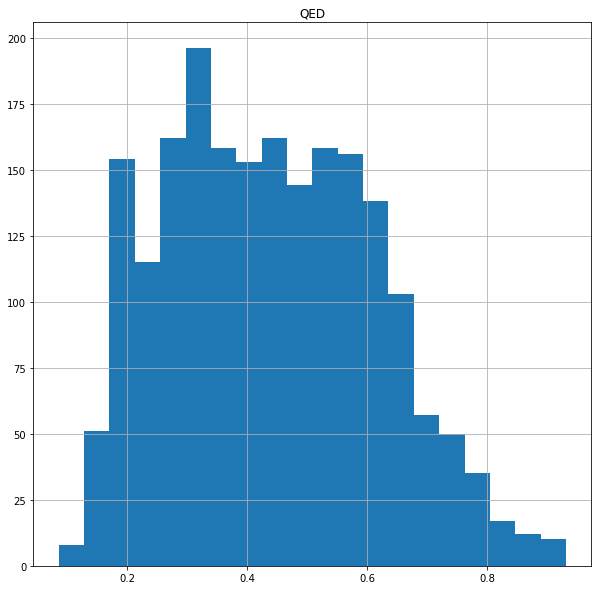

In [11]:
X_train[[MDs[-1]]].hist(bins=20, grid=True, figsize=(10, 10))

In [12]:
smiles_codes = train_data["canonical_smiles_get_levels"].copy()
target = train_data["IC50_nM"].copy()

non_idx = dt.validate_smiles(smiles_codes=smiles_codes)
smiles_codes = smiles_codes.drop(non_idx, axis=0)
target = target.drop(non_idx, axis=0)

pipeline_file = "pipeline_configuration_XGBoost_classification.json"
pipeline_configuration = dt.read_in_pipeline(pipeline_file=pipeline_file, pipeline_directory=co.PIPELINE_DIR)
pipeline = dt.create_pipeline(pipeline_configuration=pipeline_configuration["feature_transform"])

y_train = dt.process_taget(pipeline_configuration=pipeline_configuration["target_transform"], y=target)
smiles_codes = smiles_codes.loc[y_train.index]

l.info("The number of positive cases: "+str(y_train.sum()))
l.info("The number of negative cases: "+str(y_train.shape[0]-y_train.sum()))
l.info("The positive cases fraction: "+str(y_train.sum()/y_train.shape[0]))

2022-06-09 08:41:50,806 - logger - INFO - The number of positive cases: 1390
2022-06-09 08:41:50,806 - logger - INFO - The number of positive cases: 1390
2022-06-09 08:41:50,807 - logger - INFO - The number of negative cases: 649
2022-06-09 08:41:50,807 - logger - INFO - The number of negative cases: 649
2022-06-09 08:41:50,808 - logger - INFO - The positive cases fraction: 0.6817067189798921
2022-06-09 08:41:50,808 - logger - INFO - The positive cases fraction: 0.6817067189798921


# XGBoost

## Basic regression

In [13]:
PIPELINE_FILE = "pipeline_configuration_XGBoost_regression.json"

In [15]:
smiles_codes = train_data["canonical_smiles_get_levels"].copy()
target = train_data["IC50_nM"].copy()

non_idx = dt.validate_smiles(smiles_codes=smiles_codes)
smiles_codes = smiles_codes.drop(non_idx, axis=0)
target = target.drop(non_idx, axis=0)

pipeline_file = PIPELINE_FILE
pipeline_configuration = dt.read_in_pipeline(pipeline_file=pipeline_file, pipeline_directory=co.PIPELINE_DIR)
pipeline = dt.create_pipeline(pipeline_configuration=pipeline_configuration["feature_transform"])

y_train = dt.process_taget(pipeline_configuration=pipeline_configuration["target_transform"], y=target)
smiles_codes = smiles_codes.loc[y_train.index]

smiles_codes_train, smiles_codes_train_val, y_train, y_train_val = train_test_split(smiles_codes, y_train, test_size=0.1, random_state=co.RANDOM_STATE)

m_r = mw.M_XGBoost(prediction_type=mw.Prediction_Type.REGRESSION, pipeline_configuration=pipeline_configuration)
data = {"smiles_codes_train": smiles_codes_train, "targets_train": y_train, 
        "smiles_codes_val": smiles_codes_train_val, "targets_val": y_train_val}
m_r.Data = data
m_r.Create_Features()

aux_data = {"run_name": "test",
        "n_outer": 1, "n_cv": 4, "development": False,
        "goal_function": "mse", "goal_function_multiplier": 1.0, "threshold": None,
        "track_model": False, "experiment": None, "comment": None, "max_evals": None}

fmin_objective = partial(m_r.F_Opt, aux_data=aux_data)
trials = Trials()
rstate = np.random.RandomState(co.RANDOM_STATE+1)
max_evals = 150
best_hyperparams = fmin(fn=fmin_objective, space=m_r.Space, algo=tpe.suggest, max_evals=max_evals, 
                        trials=trials, return_argmin=True, rstate=rstate, show_progressbar=True)

measure = m_r.Get_Measure(smiles_codes, y_train, hyperparameters=best_hyperparams, n_outer=aux_data["n_outer"], n_cv=aux_data["n_cv"],
                          threshold=None, goal=aux_data["goal_function"]) 
   
l.info("Regressor quality after hyperparameter optimization: "+str(measure))

2022-06-09 08:42:35,562 - logger - INFO - CreateFPS transform...
2022-06-09 08:42:35,562 - logger - INFO - CreateFPS transform...
100%|██████████| 1835/1835 [00:02<00:00, 807.96it/s]


100%|██████████| 150/150 [13:21<00:00,  5.34s/it, best loss: 0.4865313191486897]


2022-06-09 08:56:08,250 - logger - INFO - Regressor quality after hyperparameter optimization: 0.4865313191486897
2022-06-09 08:56:08,250 - logger - INFO - Regressor quality after hyperparameter optimization: 0.4865313191486897


### Model storage

In [19]:
m_r_file = "regressor_xgboost_20220531.model"
m_r.Save((co.MODEL_DIR/m_r_file).absolute().as_posix())

### Final training and validation

2022-06-09 08:56:14,532 - logger - INFO - CreateFPS fit...
2022-06-09 08:56:14,532 - logger - INFO - CreateFPS fit...
2022-06-09 08:56:14,534 - logger - INFO - CreateFPS transform...
2022-06-09 08:56:14,534 - logger - INFO - CreateFPS transform...
100%|██████████| 1835/1835 [00:02<00:00, 851.82it/s]
2022-06-09 08:56:21,778 - logger - INFO - CreateFPS transform...
2022-06-09 08:56:21,778 - logger - INFO - CreateFPS transform...
100%|██████████| 204/204 [00:00<00:00, 727.04it/s]


<AxesSubplot:title={'center':'Actual vs. Predicted plot'}, xlabel='Predicted', ylabel='Actual'>

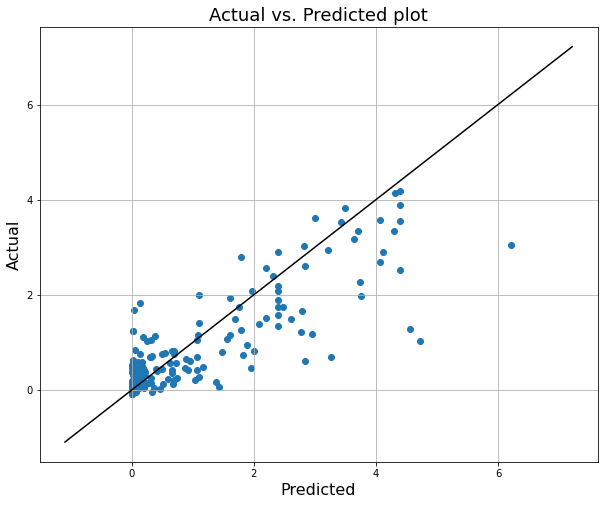

In [16]:
pipeline.fit(X=smiles_codes_train, y=None)
X_train = dt.create_molecular_features(pipeline=pipeline, smiles_codes=smiles_codes_train)
X_train = dt.process_molecular_features(pipeline=pipeline, X=X_train)

m_r.Train(X_train, y_train, hyperparameters=best_hyperparams)

X_train_val = dt.create_molecular_features(pipeline=pipeline, smiles_codes=smiles_codes_train_val)
X_train_val = dt.process_molecular_features(pipeline=pipeline, X=X_train_val)
y_train_val_pred = m_r.Predict(X_train_val)
plotScatterWithIdeal(y_train_val.values, y_train_val_pred.values, "Actual vs. Predicted plot")

In [17]:
l.info("R2 coefficient: "+str(r2_score(y_train_val, y_train_val_pred)))

2022-06-09 08:56:26,779 - logger - INFO - R2 coefficient: 0.6973417240275794
2022-06-09 08:56:26,779 - logger - INFO - R2 coefficient: 0.6973417240275794


In [18]:
m_r.Feature_Importance()

{'fp_804': 18.97726821899414,
 'GhoseFilter': 15.791670799255371,
 'fp_725': 12.20308780670166,
 'fp_1004': 12.0628662109375,
 'fp_152': 11.885690689086914,
 'fp_115': 11.524139404296875,
 'fp_823': 10.652856826782227,
 'fp_580': 10.342880249023438,
 'MW': 10.308886528015137,
 'fp_177': 9.714940071105957,
 'fp_597': 8.90768051147461,
 'fp_314': 8.68078899383545,
 'fp_350': 8.482366561889648,
 'fp_404': 6.7076334953308105,
 'fp_591': 6.414976119995117,
 'fp_106': 6.403954029083252,
 'fp_93': 5.954243183135986,
 'fp_564': 5.894175052642822,
 'fp_146': 5.834840297698975,
 'fp_588': 5.706806182861328,
 'fp_285': 5.543318271636963,
 'fp_989': 5.208711624145508,
 'fp_863': 5.169906139373779,
 'fp_401': 5.104822158813477,
 'fp_236': 4.91397762298584,
 'fp_229': 4.831779956817627,
 'fp_162': 4.791646480560303,
 'fp_910': 4.7824201583862305,
 'fp_9': 4.762113571166992,
 'fp_484': 4.728356838226318,
 'fp_283': 4.6705803871154785,
 'SMR': 4.529778480529785,
 'fp_34': 4.218594551086426,
 'fp_927':

In [22]:
trials.losses()

[0.5869434575490596,
 0.5706827195329496,
 0.5882682746166127,
 6.23839396318006,
 0.594747477605953,
 0.6110562028061135,
 0.6351758884498495,
 1.4877736198947213,
 0.580340848960852,
 0.5845552257824572,
 0.818554464872774,
 0.7356347558668653,
 0.7291682265360122,
 0.8177752631924597,
 0.6192623690223324,
 0.6764440935944557,
 0.601393833302815,
 0.5698723649230915,
 0.8572733141515793,
 7.726745873632522,
 0.6402174093280927,
 0.6723994829351332,
 0.5747805095322511,
 0.6868707797323095,
 0.5209775592491647,
 0.5281871636918893,
 0.5340090829963601,
 0.5571499575673846,
 0.51764985507437,
 0.5167987355047176,
 0.6191971250178,
 0.5396146090748479,
 0.5415686345256276,
 0.6012128007954798,
 0.616826282428982,
 0.5621198891358304,
 0.5217127496355425,
 0.5977697069183284,
 0.5430503536761285,
 0.9159519550304013,
 0.5601288255478133,
 0.9033073385934586,
 0.5426983886431977,
 1.4296189773439087,
 0.5671432339339662,
 0.6559775313180053,
 0.537441721922719,
 0.6096482281342038,
 0.608

## Regression with polarizibility

In [14]:
PIPELINE_FILE = "pipeline_configuration_XGBoost_regression_polarizability.json"

In [15]:
smiles_codes = train_data["canonical_smiles_get_levels"].copy()
target = train_data["IC50_nM"].copy()

non_idx = dt.validate_smiles(smiles_codes=smiles_codes)
smiles_codes = smiles_codes.drop(non_idx, axis=0)
target = target.drop(non_idx, axis=0)

pipeline_file = PIPELINE_FILE
pipeline_configuration = dt.read_in_pipeline(pipeline_file=pipeline_file, pipeline_directory=co.PIPELINE_DIR)
pipeline = dt.create_pipeline(pipeline_configuration=pipeline_configuration["feature_transform"])

y_train = dt.process_taget(pipeline_configuration=pipeline_configuration["target_transform"], y=target)
smiles_codes = smiles_codes.loc[y_train.index]

pipeline.fit(X=smiles_codes, y=None)
X_train = dt.create_molecular_features(pipeline=pipeline, smiles_codes=smiles_codes)
X_train = dt.process_molecular_features(pipeline=pipeline, X=X_train)

2022-06-09 08:19:55,571 - logger - INFO - CreateFPS fit...
2022-06-09 08:19:55,571 - logger - INFO - CreateFPS fit...
2022-06-09 08:19:55,572 - logger - INFO - CreateFPS transform...
2022-06-09 08:19:55,572 - logger - INFO - CreateFPS transform...
100%|██████████| 2039/2039 [00:02<00:00, 811.12it/s]


array([[<AxesSubplot:title={'center':'apol'}>,
        <AxesSubplot:title={'center':'bpol'}>]], dtype=object)

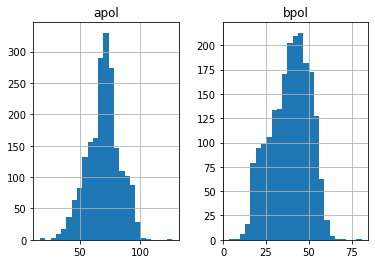

In [19]:
X_train[["apol", "bpol"]].hist(bins=25)

In [21]:
smiles_codes = train_data["canonical_smiles_get_levels"].copy()
target = train_data["IC50_nM"].copy()

non_idx = dt.validate_smiles(smiles_codes=smiles_codes)
smiles_codes = smiles_codes.drop(non_idx, axis=0)
target = target.drop(non_idx, axis=0)

pipeline_file = PIPELINE_FILE
pipeline_configuration = dt.read_in_pipeline(pipeline_file=pipeline_file, pipeline_directory=co.PIPELINE_DIR)
pipeline = dt.create_pipeline(pipeline_configuration=pipeline_configuration["feature_transform"])

y_train = dt.process_taget(pipeline_configuration=pipeline_configuration["target_transform"], y=target)
smiles_codes = smiles_codes.loc[y_train.index]

smiles_codes_train, smiles_codes_train_val, y_train, y_train_val = train_test_split(smiles_codes, y_train, test_size=0.1, random_state=co.RANDOM_STATE)

m_r = mw.M_XGBoost(prediction_type=mw.Prediction_Type.REGRESSION, pipeline_configuration=pipeline_configuration)
data = {"smiles_codes_train": smiles_codes_train, "targets_train": y_train, 
        "smiles_codes_val": smiles_codes_train_val, "targets_val": y_train_val}
m_r.Data = data
m_r.Create_Features()

aux_data = {"run_name": "test",
        "n_outer": 1, "n_cv": 4, "development": False,
        "goal_function": "mse", "goal_function_multiplier": 1.0, "threshold": None,
        "track_model": False, "experiment": None, "comment": None, "max_evals": None}

fmin_objective = partial(m_r.F_Opt, aux_data=aux_data)
trials = Trials()
rstate = np.random.RandomState(co.RANDOM_STATE+1)
max_evals = 150
best_hyperparams = fmin(fn=fmin_objective, space=m_r.Space, algo=tpe.suggest, max_evals=max_evals, 
                        trials=trials, return_argmin=True, rstate=rstate, show_progressbar=True)

measure = m_r.Get_Measure(smiles_codes, y_train, hyperparameters=best_hyperparams, n_outer=aux_data["n_outer"], n_cv=aux_data["n_cv"],
                          threshold=None, goal=aux_data["goal_function"]) 
   
l.info("Regressor quality after hyperparameter optimization: "+str(measure))

2022-06-09 08:21:23,766 - logger - INFO - CreateFPS transform...
2022-06-09 08:21:23,766 - logger - INFO - CreateFPS transform...
100%|██████████| 1835/1835 [00:02<00:00, 798.65it/s]


  0%|          | 0/150 [00:00<?, ?it/s, best loss: ?]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  1%|          | 1/150 [00:06<15:06,  6.09s/it, best loss: 0.600288358588522]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  1%|▏         | 2/150 [00:11<14:07,  5.73s/it, best loss: 0.5743661278493984]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  2%|▏         | 3/150 [00:14<10:48,  4.41s/it, best loss: 0.5743661278493984]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  3%|▎         | 4/150 [00:16<08:54,  3.66s/it, best loss: 0.5743661278493984]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  3%|▎         | 5/150 [00:22<10:08,  4.19s/it, best loss: 0.5743661278493984]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  4%|▍         | 6/150 [00:26<10:02,  4.19s/it, best loss: 0.5743661278493984]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  5%|▍         | 7/150 [00:29<09:37,  4.04s/it, best loss: 0.5743661278493984]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  5%|▌         | 8/150 [00:32<08:03,  3.40s/it, best loss: 0.5743661278493984]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  6%|▌         | 9/150 [00:35<08:02,  3.43s/it, best loss: 0.5743661278493984]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  7%|▋         | 10/150 [00:38<07:31,  3.22s/it, best loss: 0.5743661278493984]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  7%|▋         | 11/150 [00:44<09:57,  4.30s/it, best loss: 0.5743661278493984]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  8%|▊         | 12/150 [00:47<08:22,  3.64s/it, best loss: 0.5743661278493984]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  9%|▊         | 13/150 [00:50<07:51,  3.44s/it, best loss: 0.5743661278493984]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  9%|▉         | 14/150 [00:55<09:19,  4.11s/it, best loss: 0.5743661278493984]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 10%|█         | 15/150 [00:58<08:04,  3.59s/it, best loss: 0.5743661278493984]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 11%|█         | 16/150 [01:02<08:33,  3.83s/it, best loss: 0.5743661278493984]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 11%|█▏        | 17/150 [01:06<08:21,  3.77s/it, best loss: 0.5743661278493984]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 12%|█▏        | 18/150 [01:12<09:41,  4.40s/it, best loss: 0.5601903336552523]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 13%|█▎        | 19/150 [01:15<08:49,  4.04s/it, best loss: 0.5601903336552523]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 13%|█▎        | 20/150 [01:18<08:32,  3.94s/it, best loss: 0.5601903336552523]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 14%|█▍        | 21/150 [01:27<11:40,  5.43s/it, best loss: 0.5601903336552523]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 15%|█▍        | 22/150 [01:33<11:56,  5.60s/it, best loss: 0.5601903336552523]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 15%|█▌        | 23/150 [01:39<11:42,  5.53s/it, best loss: 0.5601903336552523]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 16%|█▌        | 24/150 [01:46<12:34,  5.99s/it, best loss: 0.5601903336552523]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 17%|█▋        | 25/150 [01:55<14:17,  6.86s/it, best loss: 0.5263682550435721]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 17%|█▋        | 26/150 [02:04<16:00,  7.74s/it, best loss: 0.5263682550435721]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 18%|█▊        | 27/150 [02:14<16:59,  8.29s/it, best loss: 0.5263682550435721]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 19%|█▊        | 28/150 [02:23<17:06,  8.41s/it, best loss: 0.5263682550435721]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 19%|█▉        | 29/150 [02:30<16:33,  8.21s/it, best loss: 0.5097608486947769]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 20%|██        | 30/150 [02:38<16:10,  8.09s/it, best loss: 0.5097608486947769]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 21%|██        | 31/150 [02:46<15:51,  8.00s/it, best loss: 0.5097608486947769]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 21%|██▏       | 32/150 [02:51<13:58,  7.10s/it, best loss: 0.5097608486947769]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 22%|██▏       | 33/150 [02:57<13:17,  6.82s/it, best loss: 0.5097608486947769]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 23%|██▎       | 34/150 [03:05<13:55,  7.20s/it, best loss: 0.5097608486947769]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 23%|██▎       | 35/150 [03:11<12:45,  6.65s/it, best loss: 0.5097608486947769]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 24%|██▍       | 36/150 [03:18<13:03,  6.87s/it, best loss: 0.5097608486947769]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 25%|██▍       | 37/150 [03:25<12:56,  6.87s/it, best loss: 0.5097608486947769]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 25%|██▌       | 38/150 [03:31<12:31,  6.71s/it, best loss: 0.5097608486947769]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 26%|██▌       | 39/150 [03:37<11:43,  6.34s/it, best loss: 0.5097608486947769]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 27%|██▋       | 40/150 [03:45<12:35,  6.87s/it, best loss: 0.5097608486947769]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 27%|██▋       | 41/150 [03:50<11:27,  6.30s/it, best loss: 0.5097608486947769]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 28%|██▊       | 42/150 [03:59<12:53,  7.16s/it, best loss: 0.5097608486947769]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 29%|██▊       | 43/150 [04:03<10:59,  6.16s/it, best loss: 0.5097608486947769]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 29%|██▉       | 44/150 [04:06<09:29,  5.37s/it, best loss: 0.5097608486947769]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 30%|███       | 45/150 [04:12<09:35,  5.48s/it, best loss: 0.5097608486947769]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 31%|███       | 46/150 [04:16<08:50,  5.10s/it, best loss: 0.5097608486947769]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 31%|███▏      | 47/150 [04:23<09:49,  5.72s/it, best loss: 0.5097608486947769]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 32%|███▏      | 48/150 [04:28<09:02,  5.32s/it, best loss: 0.5097608486947769]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 33%|███▎      | 49/150 [04:34<09:27,  5.62s/it, best loss: 0.5097608486947769]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 33%|███▎      | 50/150 [04:40<09:41,  5.81s/it, best loss: 0.5052418648042784]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 34%|███▍      | 51/150 [04:46<09:40,  5.87s/it, best loss: 0.49877420498588]  

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 35%|███▍      | 52/150 [04:52<09:15,  5.67s/it, best loss: 0.49877420498588]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 35%|███▌      | 53/150 [04:56<08:23,  5.19s/it, best loss: 0.49877420498588]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 36%|███▌      | 54/150 [05:02<08:36,  5.38s/it, best loss: 0.49877420498588]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 37%|███▋      | 55/150 [05:06<07:55,  5.01s/it, best loss: 0.49877420498588]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 37%|███▋      | 56/150 [05:08<06:36,  4.22s/it, best loss: 0.49877420498588]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 38%|███▊      | 57/150 [05:16<08:19,  5.37s/it, best loss: 0.49877420498588]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 39%|███▊      | 58/150 [05:22<08:16,  5.39s/it, best loss: 0.49877420498588]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 39%|███▉      | 59/150 [05:27<07:59,  5.27s/it, best loss: 0.49877420498588]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 40%|████      | 60/150 [05:32<07:50,  5.23s/it, best loss: 0.49877420498588]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 41%|████      | 61/150 [05:35<07:04,  4.77s/it, best loss: 0.49877420498588]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 41%|████▏     | 62/150 [05:42<07:49,  5.34s/it, best loss: 0.49877420498588]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 42%|████▏     | 63/150 [05:44<06:13,  4.29s/it, best loss: 0.49877420498588]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 43%|████▎     | 64/150 [05:48<06:08,  4.28s/it, best loss: 0.49877420498588]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 43%|████▎     | 65/150 [05:52<06:04,  4.29s/it, best loss: 0.49877420498588]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 44%|████▍     | 66/150 [05:59<07:03,  5.04s/it, best loss: 0.49877420498588]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 45%|████▍     | 67/150 [06:06<07:34,  5.48s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 45%|████▌     | 68/150 [06:12<07:42,  5.64s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 46%|████▌     | 69/150 [06:18<07:48,  5.79s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 47%|████▋     | 70/150 [06:25<08:09,  6.12s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 47%|████▋     | 71/150 [06:32<08:21,  6.35s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 48%|████▊     | 72/150 [06:38<08:20,  6.41s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 49%|████▊     | 73/150 [06:44<07:57,  6.20s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 49%|████▉     | 74/150 [06:51<08:07,  6.42s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 50%|█████     | 75/150 [06:56<07:40,  6.14s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 51%|█████     | 76/150 [07:04<07:59,  6.49s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 51%|█████▏    | 77/150 [07:10<07:58,  6.56s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 52%|█████▏    | 78/150 [07:16<07:41,  6.41s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 53%|█████▎    | 79/150 [07:21<06:51,  5.80s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 53%|█████▎    | 80/150 [07:29<07:25,  6.37s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 54%|█████▍    | 81/150 [07:36<07:49,  6.80s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 55%|█████▍    | 82/150 [07:44<07:58,  7.04s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 55%|█████▌    | 83/150 [07:49<07:16,  6.52s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 56%|█████▌    | 84/150 [07:54<06:36,  6.00s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 57%|█████▋    | 85/150 [08:00<06:22,  5.88s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 57%|█████▋    | 86/150 [08:05<06:14,  5.86s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 58%|█████▊    | 87/150 [08:12<06:26,  6.13s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 59%|█████▊    | 88/150 [08:20<06:51,  6.64s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 59%|█████▉    | 89/150 [08:28<07:07,  7.00s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 60%|██████    | 90/150 [08:35<06:56,  6.95s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 61%|██████    | 91/150 [08:38<05:52,  5.98s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 61%|██████▏   | 92/150 [08:46<06:13,  6.43s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 62%|██████▏   | 93/150 [08:50<05:19,  5.61s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 63%|██████▎   | 94/150 [08:56<05:30,  5.91s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 63%|██████▎   | 95/150 [09:00<04:57,  5.40s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 64%|██████▍   | 96/150 [09:04<04:25,  4.91s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 65%|██████▍   | 97/150 [09:10<04:31,  5.12s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 65%|██████▌   | 98/150 [09:16<04:43,  5.44s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 66%|██████▌   | 99/150 [09:20<04:08,  4.87s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 67%|██████▋   | 100/150 [09:24<04:00,  4.81s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 67%|██████▋   | 101/150 [09:30<04:15,  5.21s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 68%|██████▊   | 102/150 [09:38<04:45,  5.95s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 69%|██████▊   | 103/150 [09:47<05:18,  6.78s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 69%|██████▉   | 104/150 [09:54<05:14,  6.83s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 70%|███████   | 105/150 [09:58<04:37,  6.17s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 71%|███████   | 106/150 [10:05<04:41,  6.40s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 71%|███████▏  | 107/150 [10:09<04:04,  5.68s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 72%|███████▏  | 108/150 [10:14<03:44,  5.34s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 73%|███████▎  | 109/150 [10:20<03:51,  5.65s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 73%|███████▎  | 110/150 [10:26<03:50,  5.75s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 74%|███████▍  | 111/150 [10:35<04:20,  6.67s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 75%|███████▍  | 112/150 [10:40<03:51,  6.10s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 75%|███████▌  | 113/150 [10:44<03:25,  5.55s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 76%|███████▌  | 114/150 [10:51<03:40,  6.13s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 77%|███████▋  | 115/150 [10:56<03:21,  5.75s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 77%|███████▋  | 116/150 [11:04<03:33,  6.27s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 78%|███████▊  | 117/150 [11:11<03:32,  6.45s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 79%|███████▊  | 118/150 [11:16<03:18,  6.21s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 79%|███████▉  | 119/150 [11:24<03:27,  6.69s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 80%|████████  | 120/150 [11:27<02:43,  5.46s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 81%|████████  | 121/150 [11:30<02:19,  4.80s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 81%|████████▏ | 122/150 [11:35<02:16,  4.86s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 82%|████████▏ | 123/150 [11:41<02:19,  5.18s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 83%|████████▎ | 124/150 [11:47<02:20,  5.42s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 83%|████████▎ | 125/150 [11:54<02:25,  5.81s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 84%|████████▍ | 126/150 [12:02<02:41,  6.72s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 85%|████████▍ | 127/150 [12:12<02:51,  7.48s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 85%|████████▌ | 128/150 [12:17<02:27,  6.71s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 86%|████████▌ | 129/150 [12:22<02:15,  6.45s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 87%|████████▋ | 130/150 [12:27<01:58,  5.93s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 87%|████████▋ | 131/150 [12:29<01:30,  4.78s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 88%|████████▊ | 132/150 [12:34<01:28,  4.90s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 89%|████████▊ | 133/150 [12:37<01:12,  4.29s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 89%|████████▉ | 134/150 [12:45<01:26,  5.39s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 90%|█████████ | 135/150 [12:55<01:39,  6.66s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 91%|█████████ | 136/150 [13:02<01:33,  6.71s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 91%|█████████▏| 137/150 [13:08<01:26,  6.69s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 92%|█████████▏| 138/150 [13:16<01:24,  7.04s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 93%|█████████▎| 139/150 [13:21<01:10,  6.42s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 93%|█████████▎| 140/150 [13:29<01:08,  6.84s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 94%|█████████▍| 141/150 [13:36<01:00,  6.76s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 95%|█████████▍| 142/150 [13:45<01:00,  7.60s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 95%|█████████▌| 143/150 [13:56<01:00,  8.59s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 96%|█████████▌| 144/150 [14:01<00:45,  7.57s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 97%|█████████▋| 145/150 [14:08<00:35,  7.18s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 97%|█████████▋| 146/150 [14:14<00:28,  7.06s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 98%|█████████▊| 147/150 [14:22<00:21,  7.13s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 99%|█████████▊| 148/150 [14:28<00:13,  6.90s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 99%|█████████▉| 149/150 [14:36<00:07,  7.17s/it, best loss: 0.48587555005526456]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



100%|██████████| 150/150 [14:41<00:00,  5.87s/it, best loss: 0.48587555005526456]


/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
2022-06-09 08:36:17,193 - logger - INFO - Regressor quality after hyperparameter optimization: 0.48587555005526456
2022-06-09 08:36:17,193 - logger - INFO - Regressor quality after hyperparameter optimization: 0.48587555005526456


2022-06-09 08:36:18,973 - logger - INFO - CreateFPS fit...
2022-06-09 08:36:18,973 - logger - INFO - CreateFPS fit...
2022-06-09 08:36:18,975 - logger - INFO - CreateFPS transform...
2022-06-09 08:36:18,975 - logger - INFO - CreateFPS transform...
100%|██████████| 1835/1835 [00:02<00:00, 847.94it/s]
/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
2022-06-09 08:36:26,599 - logger - INFO - CreateFPS transform...
2022-06-09 08:36:26,599 - logger - INFO - CreateFPS transform...
100%|██████████| 204/204 [00:00<00:00, 750.89it/s]


<AxesSubplot:title={'center':'Actual vs. Predicted plot'}, xlabel='Predicted', ylabel='Actual'>

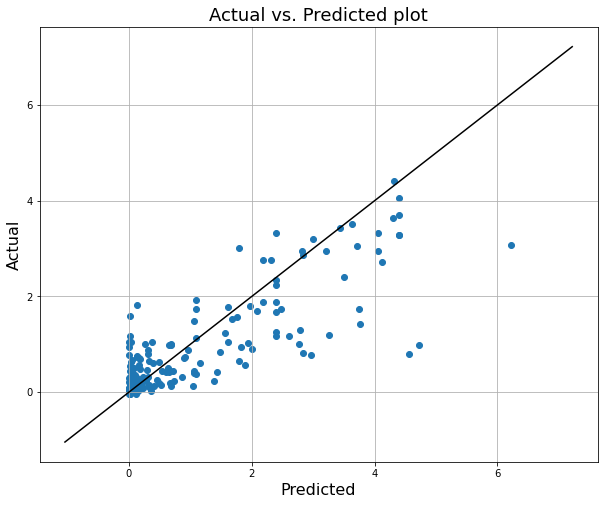

In [22]:
pipeline.fit(X=smiles_codes_train, y=None)
X_train = dt.create_molecular_features(pipeline=pipeline, smiles_codes=smiles_codes_train)
X_train = dt.process_molecular_features(pipeline=pipeline, X=X_train)

m_r.Train(X_train, y_train, hyperparameters=best_hyperparams)

X_train_val = dt.create_molecular_features(pipeline=pipeline, smiles_codes=smiles_codes_train_val)
X_train_val = dt.process_molecular_features(pipeline=pipeline, X=X_train_val)
y_train_val_pred = m_r.Predict(X_train_val)
plotScatterWithIdeal(y_train_val.values, y_train_val_pred.values, "Actual vs. Predicted plot")

In [24]:
l.info("R2 coefficient: "+str(r2_score(y_train_val, y_train_val_pred)))

2022-06-09 08:38:01,705 - logger - INFO - R2 coefficient: 0.6751555005941816
2022-06-09 08:38:01,705 - logger - INFO - R2 coefficient: 0.6751555005941816


In [25]:
m_r.Feature_Importance()

{'fp_798': 53.11470031738281,
 'fp_521': 9.65142822265625,
 'fp_1004': 9.307426452636719,
 'fp_973': 8.858156204223633,
 'fp_314': 6.970853805541992,
 'fp_725': 6.534375190734863,
 'fp_404': 5.675065517425537,
 'Lipinski': 5.660096168518066,
 'fp_349': 5.46228551864624,
 'fp_38': 5.200401782989502,
 'MW': 5.042518138885498,
 'fp_151': 4.9995832443237305,
 'fp_927': 4.700810432434082,
 'fp_836': 4.348144054412842,
 'fp_152': 4.250135898590088,
 'fp_887': 4.184691905975342,
 'fp_681': 3.8671391010284424,
 'fp_531': 3.787841796875,
 'fp_303': 3.727410078048706,
 'fp_664': 3.341935634613037,
 'fp_179': 3.3111979961395264,
 'fp_484': 3.1991758346557617,
 'fp_401': 3.152003526687622,
 'apol': 3.0789403915405273,
 'fp_233': 3.0135555267333984,
 'fp_824': 2.927577495574951,
 'fp_828': 2.866658926010132,
 'fp_408': 2.8528575897216797,
 'fp_804': 2.784808397293091,
 'fp_766': 2.7091290950775146,
 'fp_299': 2.694688558578491,
 'fp_441': 2.5183651447296143,
 'fp_737': 2.4914581775665283,
 'fp_283'

## Classification

In [26]:
smiles_codes = train_data["canonical_smiles_get_levels"].copy()
target = train_data["IC50_nM"].copy()

non_idx = dt.validate_smiles(smiles_codes=smiles_codes)
smiles_codes = smiles_codes.drop(non_idx, axis=0)
target = target.drop(non_idx, axis=0)

pipeline_file = "pipeline_configuration_XGBoost_classification.json"
pipeline_configuration = dt.read_in_pipeline(pipeline_file=pipeline_file, pipeline_directory=co.PIPELINE_DIR)
pipeline = dt.create_pipeline(pipeline_configuration=pipeline_configuration["feature_transform"])

y_train = dt.process_taget(pipeline_configuration=pipeline_configuration["target_transform"], y=target)
smiles_codes = smiles_codes.loc[y_train.index]

smiles_codes_train, smiles_codes_train_val, y_train, y_train_val = train_test_split(smiles_codes, y_train, test_size=0.1, random_state=co.RANDOM_STATE)

m_c = mw.M_XGBoost(prediction_methodology=mw.Prediction_Methodology.XGBOOST, 
                   prediction_type=mw.Prediction_Type.CLASSIFICATION, pipeline_configuration=pipeline_configuration)
data = {"smiles_codes_train": smiles_codes_train, "targets_train": y_train, 
        "smiles_codes_val": smiles_codes_train_val, "targets_val": y_train_val}
m_c.Data = data
m_c.Create_Features()

aux_data = {"run_name": "test",
           "n_outer": 1, "n_cv": 4, "development": False,
           "goal_function": "precision", "goal_function_multiplier": -1.0, "threshold": 0.5,
           "track_model": False, "experiment": None, "comment": None, "max_evals": None}

fmin_objective = partial(m_c.F_Opt, aux_data=aux_data)
trials = Trials()
rstate = np.random.RandomState(co.RANDOM_STATE+1)
max_evals = 150
best_hyperparams = fmin(fn=fmin_objective, space=m_c.Space, algo=tpe.suggest, max_evals=max_evals, 
                        trials=trials, return_argmin=True, rstate=rstate, show_progressbar=True)

measure = m_c.Get_Measure(smiles_codes, y_train, hyperparameters=best_hyperparams, n_outer=aux_data["n_outer"], n_cv=aux_data["n_cv"],
                        threshold=aux_data["threshold"], goal=aux_data["goal_function"])

l.info("Regressor quality after hyperparameter optimization: "+str(measure))

2022-06-03 00:57:33,736 - logger - INFO - CreateFPS transform...
2022-06-03 00:57:33,736 - logger - INFO - CreateFPS transform...
100%|██████████| 1835/1835 [00:02<00:00, 882.73it/s]


100%|██████████| 150/150 [09:12<00:00,  3.68s/trial, best loss: -0.8895705521472392]


2022-06-03 01:06:59,518 - logger - INFO - Regressor quality after hyperparameter optimization: 0.8895705521472392
2022-06-03 01:06:59,518 - logger - INFO - Regressor quality after hyperparameter optimization: 0.8895705521472392


### Model storage

In [27]:
m_c_file = "classifier_xgboost_20220531.model"
m_c.Save((co.MODEL_DIR/m_c_file).absolute().as_posix())

### Final training and validation

2022-06-03 01:07:15,924 - logger - INFO - CreateFPS fit...
2022-06-03 01:07:15,924 - logger - INFO - CreateFPS fit...
2022-06-03 01:07:15,926 - logger - INFO - CreateFPS transform...
2022-06-03 01:07:15,926 - logger - INFO - CreateFPS transform...
100%|██████████| 1835/1835 [00:02<00:00, 903.40it/s]
2022-06-03 01:07:23,906 - logger - INFO - CreateFPS transform...
2022-06-03 01:07:23,906 - logger - INFO - CreateFPS transform...
100%|██████████| 204/204 [00:00<00:00, 779.99it/s]


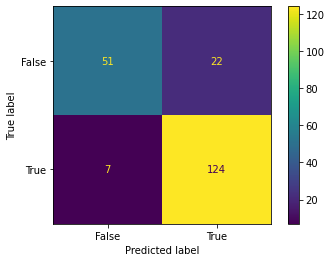

In [28]:
pipeline.fit(X=smiles_codes_train, y=None)
X_train = dt.create_molecular_features(pipeline=pipeline, smiles_codes=smiles_codes_train)
X_train = dt.process_molecular_features(pipeline=pipeline, X=X_train)

m_c.Train(X_train, y_train, hyperparameters=best_hyperparams)

X_train_val = dt.create_molecular_features(pipeline=pipeline, smiles_codes=smiles_codes_train_val)
X_train_val = dt.process_molecular_features(pipeline=pipeline, X=X_train_val)
y_train_val_pred = m_c.Predict(X_train_val)

plot_confusion_matrix(m_c.Model, X_train_val, y_train_val)

In [24]:
l.info("Recall score: "+str(recall_score(y_train_val, y_train_val_pred > aux_data["threshold"])))
l.info("Precision score: "+str(precision_score(y_train_val, y_train_val_pred > aux_data["threshold"])))

2022-06-03 00:56:48,056 - logger - INFO - Recall score: 0.9389312977099237
2022-06-03 00:56:48,056 - logger - INFO - Recall score: 0.9389312977099237
2022-06-03 00:56:48,059 - logger - INFO - Precision score: 0.8482758620689655
2022-06-03 00:56:48,059 - logger - INFO - Precision score: 0.8482758620689655


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

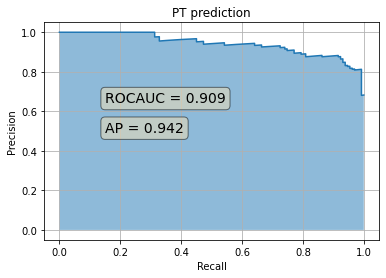

In [25]:
create_precision_recall_plot(y_train_val, y_train_val_pred)

### Confidence level

In [29]:
m_r = mw.M_XGBoost(prediction_methodology=mw.Prediction_Methodology.XGBOOST, prediction_type=mw.Prediction_Type.CLASSIFICATION, pipeline_configuration=None)
m_r.Load((co.MODEL_DIR/m_r_file).absolute().as_posix())

In [22]:
smiles_codes_train_val = m_r.Data["smiles_codes_val"]
X_train_val = dt.create_molecular_features(pipeline=m_r.Pipeline, smiles_codes=smiles_codes_train_val)
X_train_val = dt.process_molecular_features(pipeline=m_r.Pipeline, X=X_train_val)

y_pred = m_r.Predict(X_train_val)
confidence_level = 2.0 * m_c.Predict(X_train_val).apply(lambda x: 0.5-x if x < 0.5 else x-0.5)

2022-06-03 00:15:44,550 - logger - INFO - CreateFPS transform...
2022-06-03 00:15:44,550 - logger - INFO - CreateFPS transform...
100%|██████████| 204/204 [00:00<00:00, 775.68it/s]


Text(0.5, 1.0, 'Confidence level histogram')

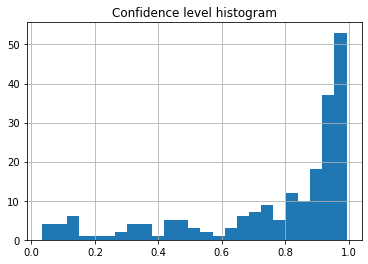

In [23]:
confidence_level.hist(bins=25)
plt.title("Confidence level histogram")

<AxesSubplot:title={'center':'Actual vs. Predicted plot'}, xlabel='Predicted', ylabel='Actual'>

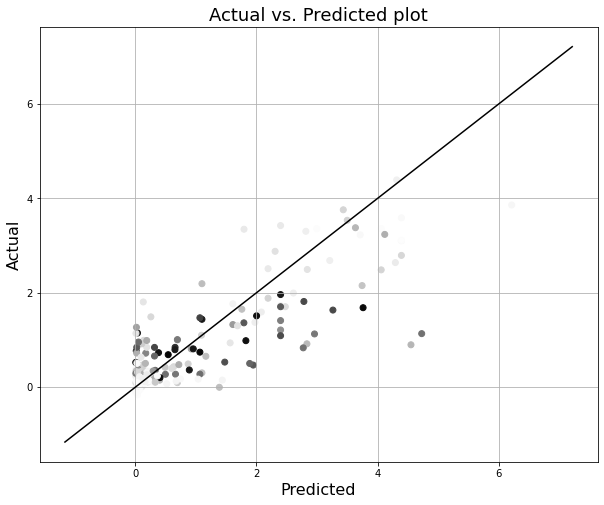

In [24]:
y_train_val_pred = m_r.Predict(X_train_val)
y_train_val_pred.columns = ["ln(IC50)_pred"]
plotScatterWithIdeal(m_r.Data["targets_val"].values, y_pred.values, "Actual vs. Predicted plot", confidence=confidence_level)

## Classifier reload

In [25]:
m_c_reload = mw.M_XGBoost(prediction_methodology=mw.Prediction_Methodology.XGBOOST, prediction_type=mw.Prediction_Type.CLASSIFICATION, 
                                     pipeline_configuration=None)
m_c_reload.Load((co.MODEL_DIR/m_c_file).absolute().as_posix())
y_pred_2 = m_c_reload.Predict(X_train_val)

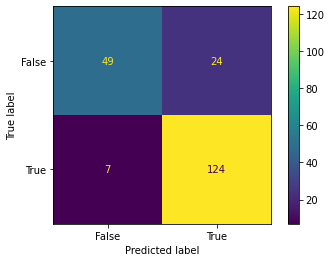

In [26]:
plot_confusion_matrix(m_c_reload.Model, X_train_val, y_train_val)

In [27]:
l.info("Recall score: "+str(recall_score(y_train_val, y_pred_2 > aux_data["threshold"])))
l.info("Precision score: "+str(precision_score(y_train_val, y_pred_2 > aux_data["threshold"])))

2022-06-03 00:16:21,621 - logger - INFO - Recall score: 0.9465648854961832
2022-06-03 00:16:21,621 - logger - INFO - Recall score: 0.9465648854961832
2022-06-03 00:16:21,624 - logger - INFO - Precision score: 0.8378378378378378
2022-06-03 00:16:21,624 - logger - INFO - Precision score: 0.8378378378378378


# MLP

## Regressor

In [ ]:
pipeline_file = "pipeline_configuration_XGBoost_regression.json"
pipeline_configuration = dt.read_in_pipeline(pipeline_file=pipeline_file, pipeline_directory=PIPELINE_DIR)

X_train = pd.DataFrame(train_data[smiles_column])
# just to get the validataion smiles for model wrapper (vide infra)
X_train_cpy = X_train.copy(deep=True)
y_train = pd.DataFrame(train_data[target_column])

include_O_removal = False
include_Target_Transform = True
include_Target_Binarization = False

pipeline_train = dt.create_pipeline(pipeline_configuration, smiles_column=smiles_column, target_column=target_column)

X_train, y_train = dt.create_molecular_features(pipeline=pipeline_train, X=X_train, include_O_removal=include_O_removal, 
                                                include_Target_Transform=include_Target_Transform, include_Target_Binarization=include_Target_Binarization,
                                                y=y_train, smiles_column=smiles_column, target_column=target_column)

# An internal split for objective checking
X_train, X_train_val, y_train, y_train_val = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_STATE)
# For later use witin the wrapper
X_train_val_smiles = X_train_cpy.loc[X_train_val.index, :].copy(deep=True)
del X_train_cpy

In [ ]:
m_r = model_wrapper.M_MLP(prediction_methodology=model_wrapper.Prediction_Methodology.MLP, prediction_type=model_wrapper.Prediction_Type.REGRESSION)
data = {"X_train": X_train, "X_train_val": X_train_val, "y_train": y_train, "y_train_val": y_train_val}
m_r.Data = data

In [ ]:
m_r = model_wrapper.M_XGBoost(methodology="XGBoost_regression", prediction_type=model_wrapper.Prediction_Type.REGRESSION)
data = {"X_train": X_train, "X_train_val": X_train_val, "y_train": y_train, "y_train_val": y_train_val}
m_r.Data = data

l.info("Training set size: "+str(X_train.shape[0]))
aux_data = {"run_name": "test",
           "n_outer": 1, "n_cv": 4, "development": False,
           "goal_function": "mse", "goal_function_multiplier": 1.0, "threshold": None,
           "track_model": False, "experiment": None, "comment": None, "max_evals": None}

fmin_objective = partial(m_r.F_Opt, aux_data=aux_data)
trials = Trials()
rstate = np.random.RandomState(random_seed+1)
max_evals = 50
best_hyperparams = fmin(fn=fmin_objective, space=m_r.Space, algo=tpe.suggest, max_evals=max_evals, 
                        trials=trials, return_argmin=True, rstate=rstate)

In [ ]:
if not simple_preprocessing:
    from sklearn.impute import KNNImputer
    imputer = KNNImputer(n_neighbors=5, weights="uniform")
    imputed_data = imputer.fit_transform(molecular_descriptors_cleaned.drop('activity_get_all_levels', axis=1))
    imputed_data = pd.DataFrame(imputed_data, index=molecular_descriptors_cleaned.index, 
                                columns=molecular_descriptors_cleaned.columns[:-1])
    molecular_descriptors_imputed = pd.concat([imputed_data, molecular_descriptors_cleaned['activity_get_all_levels']], axis=1)
    print(molecular_descriptors_imputed.isna().sum().sum())

In [ ]:
if simple_preprocessing:
    molecular_descriptors_imputed = molecular_descriptors_cleaned

## Molecular fingerprint

In [ ]:
finger_print_size = 1024
fps = [Chem.RDKFingerprint(x, fpSize=finger_print_size) for x in mol_objs]

fps_bin = []
for item in fps: fps_bin.append(DataStructs.BitVectToText(item))
    
tmp = []
for idx in range(len(fps_bin)):
    tmp.append([item for item in fps_bin[idx]])
    
tmp = pd.DataFrame(tmp)
tmp = tmp.astype(int)

tmp.columns = ['fp_'+str(idx) for idx in range(tmp.shape[1])]
tmp = tmp.set_index(molecular_descriptors.index)

molecular_descriptors_imputed = pd.concat([molecular_descriptors_imputed, tmp], axis=1)

del tmp

In [ ]:
molecular_descriptors_imputed

In [ ]:
molecular_descriptors_imputed.shape

In [ ]:
fp_col = []
for item in molecular_descriptors_imputed.columns:
    if item.startswith('fp_'): fp_col.append(item)

In [ ]:
molecular_descriptors_imputed[fp_col].sum(axis=1)

In [ ]:
molecular_descriptors_imputed['fpsum'] = molecular_descriptors_imputed[fp_col].sum(axis=1)

In [ ]:
molecular_descriptors_imputed['fpsum'].hist()

In [ ]:
def create_histograms(df, label):
    feature_list = df.columns
    n_columns = 5
    n_rows = int(np.ceil(len(feature_list) / n_columns))
    
    n_rows_to_size = int(2.2 * n_rows)
    fig = plt.figure(figsize=(15, n_rows_to_size))
    
    for idx, feature in enumerate(feature_list):
        plt.subplot(n_rows, n_columns, idx+1)
        f = plt.gca()
        f.axes.get_yaxis().set_visible(False)
        f.set_title(feature)

        plt.hist(df[feature], color='#3F5D7D')
        plt.grid(True)
    fig.suptitle('Set of molecular descriptors, batch: '+str(label), fontsize=16, y=1.00)
    plt.tight_layout()
    fig.patch.set_facecolor('white')
    plt.savefig('molecular_descriptors_histogram_'+str(label)+'.png')
    plt.close(fig)

In [ ]:
features_all = molecular_descriptors_cleaned.drop([activity_label], axis=1).columns.to_list()
features_ohe = ['GhoseFilter', 'Lipinski']
features_fp = [item for item in features_all if item.startswith('fp_')]
features_scaling = list(set(features_all) - set(features_ohe) - set(features_fp))

In [ ]:
not_to_be_plotted

In [ ]:
molecular_descriptors_cleaned.drop(not_to_be_plotted, axis=1)

In [ ]:
do_plots = True
if do_plots:
    not_to_be_plotted = features_ohe+features_fp+[activity_label]
    to_be_plotted = molecular_descriptors_cleaned.drop(not_to_be_plotted, axis=1)
    n_plots_per_batch = 50
    n_batches = int(np.ceil(to_be_plotted.shape[1] / n_plots_per_batch))    
    for idx in range(n_batches):
        n_beg = idx * n_plots_per_batch
        n_end = (idx+1) * n_plots_per_batch
        create_histograms(to_be_plotted.iloc[:, n_beg:n_end], idx)

In [ ]:
molecular_descriptors_cleaned

In [ ]:
final_data_frame = 'molecular_descriptors_cleaned.parquet'
molecular_descriptors_cleaned.to_parquet(final_data_frame, index=True)

## QSAR model

In [ ]:
class DataScaling(BaseEstimator, TransformerMixin):
    def __init__(self, scaler, features_all, features_scaling):
        logging.info('Scaler constructor...')
        self.scaler = scaler
        self.features_all = features_all
        self.features_scaling = features_scaling
        self.features_remaining = list(set(features_all) - set(features_scaling))
    
    def fit(self, X, y = None):
        logging.info('Scaler fit...')
        logging.info('I do fit a scaler')

        self.scaler.fit(X[self.features_scaling])
        return self
    
    def transform(self, X, y = None):
        logging.info('Scaler transform...')

        scaled_data = self.scaler.transform(X[self.features_scaling])
        scaled_data = pd.DataFrame(scaled_data, columns=self.features_scaling, index=X.index)
        entire_data = pd.concat([scaled_data, X[self.features_remaining]], axis=1)
        all_features = sorted(entire_data.columns.tolist())
        return entire_data[all_features]
    
    @property
    def get_scaler(self):
        return self.scaler

In [ ]:
class DataOHE(BaseEstimator, TransformerMixin):
    def __init__(self, features_all, features_ohe):
        self.features_ohe = features_ohe
        self.features_remaining = list(set(features_all) - set(features_ohe))
        self.ohe = OneHotEncoder()
    
    def fit(self, X, y=None):
        OHE_to_be_fit = X[self.features_ohe]
        self.ohe.fit(OHE_to_be_fit)
        return self
    
    def transform(self, X, y=None):
        logging.info('Entering transform')
        oheFeatures = self.ohe.transform(X[self.features_ohe]).toarray()
        entire_data = pd.concat([X[self.features_remaining], 
                                pd.DataFrame(oheFeatures, index=X.index, columns=self.ohe.get_feature_names())], 
                                axis=1)
        all_features = sorted(entire_data.columns.tolist())
        return entire_data[all_features]

    @property
    def get_ohe(self):
        return self.ohe
    
    @property
    def feature_names(self):
        return self.ohe.get_feature_names()

In [ ]:
class DataPCA(BaseEstimator, TransformerMixin):
    def __init__(self, n_percent, n_components, random_seed, retain_native, features, label):
        self.n_percent = n_percent
        self.n_components = n_components
        self.random_seed = random_seed
        self.retain_native = retain_native
        self.features = features
        self.label = label
        
    def fit(self, X, y=None):
        logging.info('Fitting PCA')        
        self._pca = self._fit_PCA(X)
        return self
        
    def _fit_PCA(self, X):
        pca = PCA(n_components=self.n_components, random_seed=self.random_seed)
        return pca.fit(X[self.features])
        
    def transform(self, X, y=None):
        logging.info('Transforming PCA')
        pca_transformed = self._transform_PCA(X[self.features])
        
        if self.retain_native:
            return pd.concat([pca_transformed, X], axis=1)
        else:
            return pca_transformed
        
    def _transform_PCA(self, X):
        if self.n_percent is not None:
            pca_cum = self._pca.explained_variance_ratio_.cumsum()
            pca_n = (pca_cum < self.n_percent).sum()
            print('!!! ', pca_n, pca_cum)
        else:
            pca_n = self.n_components
                
        pca_transformed = self._pca.transform(X[self.features])
        pca_transformed = pd.DataFrame(data=pca_transformed[:, :pca_n], index = X.index, 
                                       columns=[self.label+'-pca_'+str(iii) for iii in range(pca_n)])
        return pca_transformed
    
    @property
    def pca(self):
        return self._pca

In [ ]:
steps = []
scaler = StandardScaler()

steps.append(('Scaling', DataScaling(scaler, features_all, features_scaling)))
steps.append(('One-hot encoding', DataOHE(features_all, features_ohe)))

pipeline = Pipeline(steps=steps)

In [ ]:
pipeline.fit(molecular_descriptors_cleaned)
molecular_descriptors_transformed = pipeline.transform(molecular_descriptors_cleaned)

In [ ]:
molecular_descriptors_transformed

In [ ]:
molecular_descriptors_cleaned.shape

In [ ]:
set(molecular_descriptors_transformed.columns.tolist()) - set(molecular_descriptors_cleaned.columns.tolist())

In [ ]:
set(molecular_descriptors_cleaned.columns.tolist()) - set(molecular_descriptors_transformed.columns.tolist())

## TBD - include PCA in pipeline

In [ ]:
pca = DataPCA(None, 100, 42, False, features_no_categorical, 'transformed')

In [ ]:
pca.fit(molecular_descriptors_cleaned)

In [ ]:
pca.transform(molecular_descriptors_cleaned, 'pca')

In [ ]:
pca.pca.explained_variance_ratio_

## TBD - include PCA in pipeline

In [ ]:
X = molecular_descriptors_transformed
y = data_aggregated.loc[molecular_descriptors_cleaned.index, 'activity']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=random_seed)

* Feature selection - remove features (columns) with low variance

In [ ]:
labels_to_bool = {'active': True, 'inactive':False}
labels_to_numbers = {'active': 1, 'inactive':0}

In [ ]:
experiment = 'RORgamma_homo_sapiens_xgboost'
set_up_mlflow(experiment)

In [ ]:
def do_xgboost(X_train, X_test, y_train, y_test, run_name, register_model, goal_function, **kwargs):
    with mlflow.start_run(run_name=run_name):
        
        #take stuff from kwargs
        if 'n_estimators' in kwargs.keys():
            n_estimators = kwargs['n_estimators']
        else:
            n_estimators = 20

        if 'max_depth' in kwargs.keys():
            max_depth = kwargs['max_depth']
        else:
            max_depth = 20
            
        if 'min_child_weight' in kwargs.keys():
            min_child_weight = kwargs['min_child_weight']
        else:
            min_child_weight = 1
            
        if 'eta' in kwargs.keys():
            eta = kwargs['eta']
        else:
            eta = 0.3

        if 'subsample' in kwargs.keys():
            subsample = kwargs['subsample']
        else:
            subsample = 0.3
            
        if 'colsample_bytree' in kwargs.keys():
            colsample_bytree = kwargs['colsample_bytree']
        else:
            colsample_bytree = 1
            
        if 'gamma' in kwargs.keys():
            gamma = kwargs['gamma']
        else:
            gamma = 0.0

        if 'vt_threshold' in kwargs.keys():
            vt_threshold = kwargs['vt_threshold']
        else:
            vt_threshold = 0.5
        
        if 'reg_alpha' in kwargs.keys():
            reg_alpha = kwargs['reg_alpha']
        else:
            reg_alpha = 0
            
        if 'reg_lambda' in kwargs.keys():
            reg_lambda = kwargs['reg_lambda']
        else:
            reg_lambda = 1
            
        if 'objective' in kwargs.keys():
            objective = kwargs['objective']
        else:
            objective = 'reg:logistic'



        mlflow.log_param('n_estimators', n_estimators)
        mlflow.log_param('max_depth', max_depth)
        mlflow.log_param('min_child_weight', min_child_weight)
        mlflow.log_param('eta', eta)
        mlflow.log_param('subsample', subsample)
        mlflow.log_param('colsample_bytree', colsample_bytree)
        mlflow.log_param('gamma', gamma)
        mlflow.log_param('reg_alpha', reg_alpha)
        mlflow.log_param('reg_lambda', reg_lambda)
        mlflow.log_param('vt_threshold', vt_threshold)
        
        mlflow.log_param('objective', objective)
        
        
        
        vt = VarianceThreshold(threshold=vt_threshold)
        _ = vt.fit_transform(X_train)
        feature_subset = X_train.columns[vt.get_support()]

        X_train_sub = X_train[feature_subset]
        X_test_sub = X_test[feature_subset]

        # train
        classifier = XGBClassifier(max_depth=max_depth, n_estimators=n_estimators, min_child_weight=min_child_weight,
                                   subsample=subsample, colsample_bytree=colsample_bytree, eta=eta,
                                   gamma=gamma, reg_alpha=reg_alpha, reg_lambda=reg_lambda,
                                   objective=objective)
        
        classifier.fit(X_train_sub, y_train)
        
        y_pred = classifier.predict(X_test_sub)        
        
        precision = precision_score(y_test, y_pred, pos_label="active")
        recall = recall_score(y_test, y_pred, pos_label="active")
        
        mlflow.log_metric('precision', precision)
        mlflow.log_metric('recall', recall)
        
        y_pred_proba = classifier.predict_proba(X_test_sub)
        average_precision = average_precision_score(y_test, y_pred_proba[:, 0], pos_label="active")
        mlflow.log_metric('average_precision', average_precision)

        #signature = infer_signature(X_train, classifier.predict(X_train))
        if register_model:
            mlflow.xgboost.log_model(classifier.get_booster(), 'model')

        mlflow.log_param('n_features', len(feature_subset))

        auxiliary_information = {}
        auxiliary_information['features'] = feature_subset.tolist()
        auxiliary_information['goal_function'] = goal_function
        #auxiliary_information['X_test'] = X_test_sub.to_json()
        #auxiliary_information['y_test'] = y_test.to_json()

        mlflow.log_dict(auxiliary_information, 'auxiliary_information')
        
        
        if goal_function == 'precision':
            goal = precision
        elif goal_function == 'recall':
            goal = recall
        elif goal_function == 'average_precision':
            goal = average_precision
        
        return classifier, feature_subset, goal

In [ ]:
def do_logistic_regression(X_train, X_test, y_train, y_test, run_name):
    with mlflow.start_run(run_name=run_name):
        lr = LogisticRegression()
        lr.fit(X_train, y_train.replace(labels_to_numbers))
        y_pred = lr.predict(X_test)

        cm = confusion_matrix(y_test.replace(labels_to_numbers), y_pred)
        precision = precision_score(y_test.replace(labels_to_numbers), y_pred)
        recall = recall_score(y_test.replace(labels_to_numbers), y_pred)
        mlflow.log_metric('precision', precision)
        mlflow.log_metric('recall', recall)
        

In [ ]:
do_logistic_regression(X_train, X_test, y_train, y_test, 'logistic regression')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=random_seed)

br = BayesianRidge()
br.fit(X_train, y_train.replace(labels_to_numbers))
y_pred = br.predict(X_test)
threshold = 0.5
y_bool = y_pred > threshold 
cm = confusion_matrix(y_test.replace(labels_to_bool), y_bool)
print(cm)
print('precision: '+str(precision_score(y_test.replace(labels_to_bool), y_bool)))
print('recall: '+str(recall_score(y_test.replace(labels_to_bool), y_bool)))
print('average precision: '+str(average_precision_score(y_test.replace(labels_to_bool), y_bool)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=random_seed)

rc = RidgeClassifier(alpha=2.0)
rc.fit(X_train, y_train.replace(labels_to_numbers))
y_pred = rc.predict(X_test)
threshold = 0.5
y_bool = y_pred > threshold 
cm = confusion_matrix(y_test.replace(labels_to_bool), y_bool)
print(cm)
print('precision: '+str(precision_score(y_test.replace(labels_to_bool), y_bool)))
print('recall: '+str(recall_score(y_test.replace(labels_to_bool), y_bool)))
print('average precision: '+str(average_precision_score(y_test.replace(labels_to_bool), y_bool)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=random_seed)

rccv = RidgeClassifierCV()
rccv.fit(X_train, y_train.replace(labels_to_numbers))
y_pred = rccv.predict(X_test)
threshold = 0.5
y_bool = y_pred > threshold 
cm = confusion_matrix(y_test.replace(labels_to_bool), y_bool)
print(cm)
print('precision: '+str(precision_score(y_test.replace(labels_to_bool), y_bool)))
print('recall: '+str(recall_score(y_test.replace(labels_to_bool), y_bool)))
print('average precision: '+str(average_precision_score(y_test.replace(labels_to_bool), y_bool)))

## Hyperparameters tuning

In [ ]:
space={'max_depth': hp.quniform('max_depth', 3, 18, 1),
       'gamma': hp.uniform('gamma', 0, 9),
       'reg_alpha' : hp.uniform('reg_alpha', 0, 2),
       'reg_lambda' : hp.uniform('reg_lambda', 0, 2),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0.6, 1.0),
       'min_child_weight' : hp.uniform('min_child_weight', 0, 10),
       'vt_threshold': hp.uniform('vt_threshold', 0, 1),
       'n_estimators': hp.quniform('n_estimators', 100, 180, 1),
       'eta': hp.uniform('eta', 0.05, 1.0),
       'subsample': hp.uniform('subsample', 0.0, 1.0),
       'seed': 0
       }

In [ ]:
def objective(space):
    register_model = False
    goal_function = 'precision'
    
    max_depth = int(space['max_depth'])
    gamma = space['gamma']
    min_child_weight=int(space['min_child_weight'])
    colsample_bytree=space['colsample_bytree']
    vt_threshold=space['vt_threshold']
    n_estimators=int(space['n_estimators'])
    eta=space['eta']
    
    reg_alpha = space['reg_alpha']
    reg_lambda = space['reg_lambda']
    subsample = space['subsample']
    
    _, _, goal_function = do_xgboost(X_train, X_test, y_train, y_test, 'xgboost', register_model=register_model, 
                                     goal_function=goal_function,
                                     gamma=gamma, min_child_weight=min_child_weight, colsample_bytree=colsample_bytree, 
                                     vt_threshold=vt_threshold, n_estimators=n_estimators, eta=eta, 
                                     max_depth=max_depth, reg_alpha=reg_alpha, reg_lambda=reg_lambda,
                                     subsample=subsample)
    return {'loss': -goal_function, 'status': STATUS_OK }

In [ ]:
trials = Trials()
best_hyperparams = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, 
                        trials=trials, return_argmin=True)

In [ ]:
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
best_hyperparams['min_child_weight'] = int(best_hyperparams['min_child_weight'])
best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])

In [ ]:
best_hyperparams

In [ ]:
goal_function = 'precision'
model_classifier, feature_subset, goal = do_xgboost(X_train, X_test, y_train, y_test, 
                                                    'optimized towards precision', True,  goal_function, **best_hyperparams)

In [ ]:
y_pred = model_classifier.predict_proba(X_test[feature_subset])
print('average precision: '+str(average_precision_score(y_test, y_pred[:, 0], pos_label="active")))

In [ ]:
y_pred = model_classifier.predict(X_test[feature_subset])
print('recall: '+str(recall_score(y_test, y_pred, pos_label="active")))
print('precision: '+str(precision_score(y_test, y_pred, pos_label="active")))
print('accuracy: '+str(accuracy_score(y_test, y_pred)))

In [ ]:
confusion_matrix(y_test, y_pred)

## Store the model on file

In [ ]:
predictive_model = {}
predictive_model['model'] = model_classifier
predictive_model['feature_subset'] = feature_subset
predictive_model['description'] = 'The model optimized towards the best recall (20210726).'

In [ ]:
with open('activity_prediction_20210726_r.pickle', 'wb') as f:
    pickle.dump(predictive_model, f)

In [ ]:
with open('activity_prediction_20210718.pickle', 'rb') as f:
    model_reloaded = pickle.load(f)

In [ ]:
#average_precision_score(y_test, y_pred, pos_label="active")

In [ ]:
def predict_activity(classifier, smiles):
    features = classifier.get_booster().feature_names
    mols = [Chem.MolFromSmiles(item) for item in smiles]
    calc = Calculator(descriptors, ignore_3D=True)
    molecular_descriptors = calc.pandas(mols)
    molecular_descriptors = molecular_descriptors[features]
    proba_prediction = classifier.predict_proba(molecular_descriptors)
    binary_prediction = classifier.predict(molecular_descriptors)
    return binary_prediction, proba_prediction

In [ ]:
smiles = ['C[C@@H]1[C@H]2C3=CC[C@@H]4[C@@]5(C)C[C@@H](O)[C@H](O)[C@@](C)(CO)[C@@H]5CC[C@@]4(C)[C@]3(C)CC[C@@]2(C(=O)O)CC[C@H]1C',
         'C[C@@H]1[C@H]2C3=CC[C@@H]4[C@@]5(C)CC[C@H](O)C(C)(C)[C@@H]5CC[C@@]4(C)[C@]3(C)CC[C@@]2(C(=O)O)CC[C@H]1C',
         'CC1CCC2(CCC3(C(=CCC4C3(CCC5C4(CC(C(C5(C)C)O)O)C)C)C2C1C)C)C(=O)O',
         'CC1(CCC2(CCC3(C(=CCC4C3(CCC5C4(CC(C(C5(C)C)O)O)C)C)C2C1)C)C(=O)O)C']
#smiles = 'COc1cc(C2NC(=O)NC(C)=C2C(=O)OCCSC)ccc1OCc1ccccc1'
binary_prediction, proba_prediction = predict_activity(classifier, smiles)

In [ ]:
smiles = ['CCCCC']
#smiles = 'COc1cc(C2NC(=O)NC(C)=C2C(=O)OCCSC)ccc1OCc1ccccc1'
binary_prediction, proba_prediction = predict_activity(classifier, smiles)

### Kwestie do przegadania
* Dane z komórek mysich - jak połączyć dane IC50 i Potency?
* Czy ma sens wypracowanie modelu łączącego dane z komórek ludzkich i mysich?
* Czy wartość progowa na poziomie 1000 nM jest sensowną propozycją rozgraniczającą układy aktywne i nieaktywne biologicznie?


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, InputLayer
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import plot_model
from tensorflow import keras
import tensorflow.keras.metrics as metrics
import tensorflow as tf
import random as rn

In [ ]:
def create_precision_recall_plot(y_test, y_pred):
    a, b, _ = precision_recall_curve(y_test, y_pred)
    plt.plot(b, a)
    plt.grid()
    plt.fill_between(b, 0, a, alpha=0.5)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    rocauc = roc_auc_score(y_test, y_pred)
    apauc = average_precision_score(y_test, y_pred)
    plt.text(0.15, 0.7, "ROCAUC = " + "{0:.3f}".format(roc_auc_score(y_test, y_pred)), fontsize=14,
             verticalalignment='top', bbox=props)
    plt.text(0.15, 0.55, "AP = " + "{0:.3f}".format(average_precision_score(y_test, y_pred)), fontsize=14,
             verticalalignment='top', bbox=props)
    plt.title("PT prediction")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.savefig(file_name.absolute().as_posix())
    return plt.figure#, file_name.absolute().as_posix()

In [ ]:
def create_mlp_model(mlp_architecture, n_features, activation, regularization_weight, optimizer='Adam'):
    model = Sequential(name='mlp_model')
    model.add(InputLayer(input_shape=(n_features,), name='input_layer'))
    for idx, dim in enumerate(mlp_architecture):
        model.add(Dense(dim, activation=activation, activity_regularizer=l1_l2(l1=regularization_weight,
                                                                               l2=regularization_weight), 
                        name='dense_'+str(idx)))
    model.add(Dense(1, activation='sigmoid', name='output_layer'))
    
    #bc = metrics.BinaryCrossentropy(name='binary_crossentropy', dtype=None, from_logits=False, label_smoothing=0)
    
    mtrcs = ['accuracy']#, bc]
    if optimizer == 'Adam':
        o = keras.optimizers.Adam()
    elif optimizer == 'SGD':
        o = keras.optimizers.SGD()
    elif optimizer == 'RMSprop':
        o = keras.optimizers.RMSprop()
    elif optimizer == 'Adagrad':
        o = keras.optimizers.Adagrad()
    elif optimizer == 'Adadelta':
        o = keras.optimizers.Adadelta()
    elif optimizer == 'Adamax':
        o = keras.optimizers.Adamax()
    elif optimizer == 'Nadam':
        o = keras.optimizers.Nadam()
    
    model.compile(optimizer=o, loss='binary_crossentropy', metrics=mtrcs)
    return model

In [ ]:
mlp_architecture = [16, 8]
n_features = X_train.shape[1]
activation = 'relu'
model = create_mlp_model(mlp_architecture, n_features, activation)

In [ ]:
model.summary()

In [ ]:
plot_model(model)

In [ ]:
def calculate_model_quality_measues(y, y_pred_proba, threshold, pos_label='active'):
    y_pred = pd.DataFrame(y_pred_proba > threshold).replace({True: 'active', False: 'inactive'})
    precision = precision_score(y, y_pred, pos_label="active")
    recall = recall_score(y, y_pred, pos_label="active")
    average_precision = average_precision_score(y, y_pred_proba, pos_label="active")
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, pos_label="active")
    cm = confusion_matrix(y, y_pred)
    return precision, recall, average_precision, accuracy, f1, cm

In [ ]:
def do_cv_mlp(X, y, run_name, checkpoint_path, n_outer, n_cv, register_model, 
              development, goal_function, **kwargs):
    
    if 'mlp_architecture' in kwargs.keys():
        mlp_architecture = kwargs['mlp_architecture']
    else:
        mlp_architecture = [128, 64, 32]
        
    if 'activation' in kwargs.keys():
        activation = kwargs['activation']
    else:
        activation = 'relu' 
        
    if 'batch_size' in kwargs.keys():
        batch_size = kwargs['batch_size']
    else:
        batch_size = 32  

    if 'optimizer' in kwargs.keys():
        optimizer = kwargs['optimizer']
    else:
        optimizer = 'Adam'

    initialize_seeds(random_seed)

    n_features = X.shape[1]
    regularization_weight = 0.075
    
    y_pred_final = np.zeros_like(y)
    for i_outer in range(n_outer):
        
        kf = KFold(n_splits=n_cv, random_state=random_seed+i_outer, shuffle=True)
        y_pred_proba = np.zeros_like(y)
        for n, (train_idx, test_idx) in enumerate(kf.split(molecular_descriptors_transformed)):
            print(i_outer, n, train_idx.sum())

            X_train = X.iloc[train_idx, :]
            X_test = X.iloc[test_idx,:]
            y_train = y.iloc[train_idx]
            y_test = y.iloc[test_idx]

            
            #vt = VarianceThreshold(threshold=vt_threshold)
            #_ = vt.fit_transform(X_train)
            #feature_subset = X_train.columns[vt.get_support()]

            #X_train_sub = X_train[feature_subset]
            #X_test_sub = X_test[feature_subset]
            
            model = create_mlp_model(mlp_architecture, n_features, activation, regularization_weight)

            val_fraction = 0.1
            val_dim = np.round(val_fraction * X_train.shape[0], 0).astype(np.int16)
            X_val = X_train.iloc[:val_dim, :]
            y_val = y_train[:val_dim]
            X_train_ = X_train.iloc[val_dim:, :]
            y_train_ = y_train[val_dim:]

            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
            early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=10, verbose=10, min_delta=0.0)
            model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=10, 
                                               save_best_only=True, save_weights_only=True, mode ='min')

            callbacks = [reduce_lr, early_stopping, model_checkpoint]

            history = model.fit(X_train_, y_train_.replace(labels_to_numbers), epochs=1024, batch_size=batch_size,
                      validation_data=(X_val, y_val.replace(labels_to_numbers)), callbacks=callbacks, verbose=0)

            model.load_weights(checkpoint_path)
            y_pred_proba[test_idx] = model.predict(X_test).flatten()
            
        y_pred_final += y_pred_proba
            
    y_pred_final /= n_outer
        
    threshold = 0.50
    precision, recall, average_precision, accuracy, f1, cm = calculate_model_quality_measues(y, y_pred_final, threshold)
    
    if goal_function == 'precision':
        goal = precision
    elif goal_function == 'recall':
        goal = recall
    elif goal_function == 'average_precision':
        goal = average_precision
    elif goal_function == 'accuracy':
        goal = accuracy

    if development:
        return y_pred_final
    else:
        return goal

In [ ]:
def do_mlp(X_train, X_test, y_train, y_test, run_name, checkpoint_path, register_model, 
           development, goal_function, **kwargs):
    
    if 'mlp_architecture' in kwargs.keys():
        mlp_architecture = kwargs['mlp_architecture']
    else:
        mlp_architecture = [128, 64, 32]
        
    if 'activation' in kwargs.keys():
        activation = kwargs['activation']
    else:
        activation = 'relu'
        
    if 'batch_size' in kwargs.keys():
        batch_size = kwargs['batch_size']
    else:
        batch_size = 32

    if 'optimizer' in kwargs.keys():
        optimizer = kwargs['optimizer']
    else:
        optimizer = 'Adam' 

    initialize_seeds(random_seed)

    n_features = X_train.shape[1]
    regularization_weight = 0.075
    
    model = create_mlp_model(mlp_architecture, n_features, activation, regularization_weight)

    val_fraction = 0.1
    val_dim = np.round(val_fraction * X_train.shape[0], 0).astype(np.int16)
    X_val = X_train.iloc[:val_dim, :]
    y_val = y_train[:val_dim]
    X_train_ = X_train.iloc[val_dim:, :]
    y_train_ = y_train[val_dim:]

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
    early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=10, verbose=10, min_delta=0.0)
    model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=10, 
                                       save_best_only=True, save_weights_only=True, mode ='min')

    callbacks = [reduce_lr, early_stopping, model_checkpoint]

    history = model.fit(X_train_, y_train_.replace(labels_to_numbers), epochs=1024, batch_size=batch_size,
              validation_data=(X_val, y_val.replace(labels_to_numbers)), callbacks=callbacks, )

    model.load_weights(checkpoint_path)

    y_pred_proba = model.predict(X_test)
    threshold = 0.50
    y_pred = pd.DataFrame(y_pred_proba > threshold).replace({True: 'active', False: 'inactive'})

    precision = precision_score(y_test, y_pred, pos_label="active")
    recall = recall_score(y_test, y_pred, pos_label="active")
    average_precision = average_precision_score(y_test, y_pred_proba, pos_label="active")
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label="active")

    cm = confusion_matrix(y_test, y_pred)

    if goal_function == 'precision':
        goal = precision
    elif goal_function == 'recall':
        goal = recall
    elif goal_function == 'average_precision':
        goal = average_precision
    elif goal_function == 'accuracy':
        goal = accuracy

    if development:
        return precision, recall, average_precision, accuracy, f1, cm, y_test, y_pred_proba, history
    else:
        return goal

## Single run, no cross-validataion

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=random_seed)
mlp_hyperparameters = {
    'mlp_architecture': [64, 32],
    'activation': 'selu',
    'batch_size': 64
}
run_name = 'mlp'
checkpoint_path = 'mlp_best_model.h5'
register_model = False
goal_function = 'precision'
y_pred_proba = do_mlp(X_train, X_test, y_train, y_test, run_name, checkpoint_path, register_model, goal_function, 
                      **mlp_hyperparameters)

In [ ]:
create_precision_recall_plot(y_test.replace(labels_to_numbers), y_pred_proba)

## Cross-validataion

In [ ]:
mlp_hyperparameters = {
    'mlp_architecture': [64, 32, 32],
    'activation': 'selu',
    'optimizer': 'Adam',
    'batch_size': 128
}
run_name = 'mlp'
checkpoint_path = 'mlp_best_model.h5'
register_model = False
goal_function = 'precision'
n_outer = 1
n_cv = 5
development = True
y_pred_proba = do_cv_mlp(X, y, run_name, checkpoint_path, n_outer, n_cv, register_model, development, goal_function, 
                         **mlp_hyperparameters)

In [ ]:
precision, recall, average_precision, accuracy, f1, cm = calculate_model_quality_measues(y, y_pred_proba, 0.5)
precision, recall, average_precision, accuracy, f1, cm

In [ ]:
thresholds = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
measures = {}
for threshold in thresholds:
    measures[threshold] = calculate_model_quality_measues(y, y_pred_proba, threshold)
measures = pd.DataFrame(measures).T
measures.columns = ['precision', 'recall', 'average_precision', 'accuracy', 'f1', 'cm']
measures

In [ ]:
create_precision_recall_plot(y.replace(labels_to_numbers), y_pred_proba)

In [ ]:
from sklearn.preprocessing import Binarizer

In [ ]:
def get_measures_for_given_threshold(y_pred, y_true, threshold=0.5):
    br = Binarizer(threshold=threshold)
    y_pred_bin = br.transform(y_pred)
    p = precision_score(y_true, y_pred_bin)
    r = recall_score(y_true, y_pred_bin)
    return p, r

In [ ]:
d = {'y_true': y.replace(labels_to_numbers).values,
     'y_pred': y_pred_proba
    }
d = pd.DataFrame(d).sort_values(['y_pred'])

In [ ]:
p, r , t = [], [], []
for tt in d['y_pred'].tolist():
    pp, rr = get_measures_for_given_threshold(d['y_pred'].values.reshape(-1, 1), 
                                              d['y_true'].values.reshape(-1, 1), tt)
    p.append(pp)
    r.append(rr)
    t.append(tt)
p_r = pd.DataFrame({'threshold': t, 'precision': p, 'recall': r})

In [ ]:
fig, ax = plt.subplots()
ax.plot(p_r['recall'], p_r['precision'])
ax.set(xlabel='recall', ylabel='precision', title='Precision/Recall plot')
ax.grid()
plt.show()

In [ ]:
space={'mlp_architecture': hp.choice('mlp_architecture', [[16, 8], [32, 16], [48, 16], [64, 16], [64, 32], [32, 16, 16], [64, 32, 32],
                                      [128, 64, 32]]),
       'activation': hp.choice('activation', ['relu', 'selu', 'elu', 'tanh']),
       'optimizer': hp.choice('optimizer', ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']),
       'batch_size': hp.choice('batch_size', [16, 32, 48, 64, 96, 128, 256])
       }

In [ ]:
49*4*7

In [ ]:
def objective(space):
    register_model = False
    goal_function = 'precision'
    
    mlp_architecture = space['mlp_architecture']
    activation = space['activation']
    optimizer = space['optimizer']
    batch_size = space['batch_size']
    
    run_name = 'mlp'
    checkpoint_path = 'mlp_best_model.h5'
    register_model = False
    goal_function = 'accuracy'
    n_outer = 1
    n_cv = 4
    development = False
    goal_function = do_cv_mlp(X, y, run_name, checkpoint_path, n_outer, n_cv, register_model, development, 
                              goal_function, 
                              mlp_architecture=mlp_architecture, activation=activation,
                              optimizer=optimizer, batch_size=batch_size)
    
    return {'loss': -goal_function, 'status': STATUS_OK }

In [ ]:
trials = Trials()
best_hyperparams = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, 
                        trials=trials, return_argmin=True)

In [ ]:
best_hyperparams